In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scripts import calculate_outliers, violin_outliers_by_gender

In [2]:
df = pd.read_csv("assets/cardio_train.csv", sep = ";").drop(columns = "id")

print(df.shape)
df.head()

(70000, 12)


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [3]:
df["age"] = df["age"] // 365

df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,47,1,156,56.0,100,60,1,1,0,0,0,0


# Disease Representation (2 A)

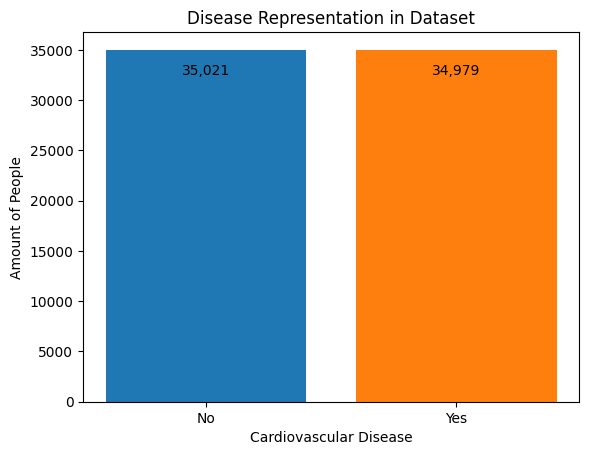

In [4]:
disease = {"No": 0, "Yes": 1}

fig, ax = plt.subplots() 

for i in disease.values(): # plot amount of each cardio value (0, 1) in df
    plt.bar(x = i, height = len(df[df["cardio"] == i]))

# set amount and position of ticks based on values, and map keys to them
plt.xticks(ticks = [value for value in disease.values()], labels = disease.keys())

for p in ax.containers: # show and format values on bars
    ax.bar_label(p, labels = [f"{val:,.0f}" for val in p.datavalues], padding = -20)

# set labels
ax.set(title = "Disease Representation in Dataset", xlabel = "Cardiovascular Disease", ylabel = "Amount of People");

# Cholesterol Levels (2 B)

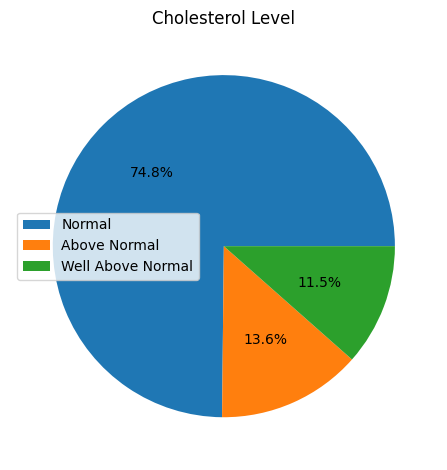

In [5]:
cholesterol = {"Normal": 1, "Above Normal": 2, "Well Above Normal": 3}

fig, ax = plt.subplots()

# plot amount of each cholesterol value (1, 2, 3) in df
plt.pie(x = [len(df[df["cholesterol"] == i]) for i in cholesterol.values()], autopct=lambda pct: f"{pct:.1f}%")

# map keys to legend
plt.legend(cholesterol.keys())

# set labels
ax.set(title = "Cholesterol Level")

plt.tight_layout()

# Age Distribution (2 C)

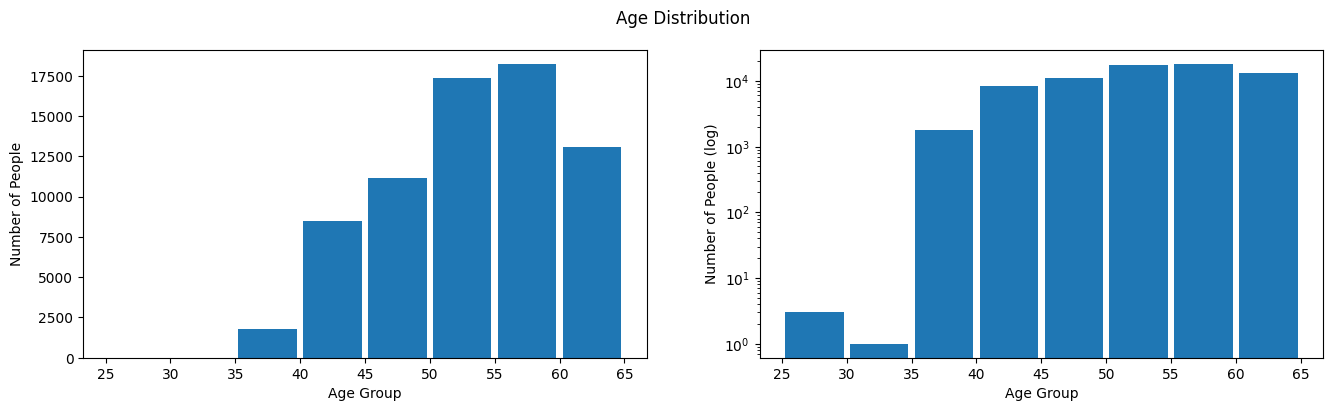

In [6]:
# pick out age groups between lowest and highest age in dataset
step = 5 # group size of bins (amount of years to group together)
start = (min(df["age"]) // step) * step # nearest multiple of [step] below min age
stop = (max(df["age"]) // step) * step + step # nearest multiple of [step] below max age, +[step] to get nearest multiple of [step] above max
bins = [i for i in range(start, stop+1, step)] # create bins list, +1 to be inclusive of last value

fig, axes = plt.subplots(1, 2, figsize = (16, 4))

# plot age grouped by bins, one normal and one log
for ax, log in zip(axes.flatten(), [False, True]):
    ax.hist(df["age"].values, bins, rwidth = 0.9, log = log) # rwidth <1 for space between bins
    ax.set(xlabel = "Age Group", ylabel = "Number of People" if log == False else "Number of People (log)") # set ylabel to reflect log state

fig.suptitle("Age Distribution");

# Smokers (2 D)

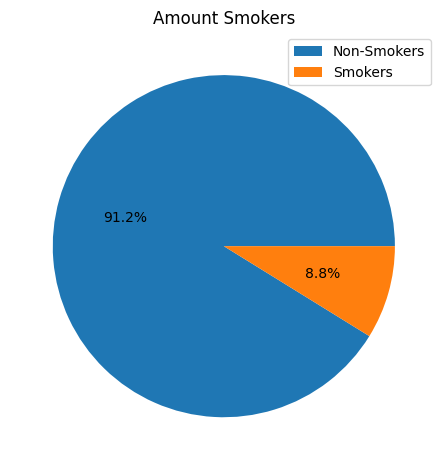

In [7]:
smoker = {"Non-Smokers": 0, "Smokers": 1}

fig, ax = plt.subplots()


# plot amount of each smoker value (0, 1) in df
plt.pie(x = [len(df[df["smoke"] == i]) for i in smoker.values()], autopct=lambda pct: f"{pct:.1f}%")

# map keys to legend
plt.legend(smoker.keys())

# set labels
ax.set(title = "Amount Smokers")

plt.tight_layout()

# Weight and Height Outlier Definition

### Below I will look at weight and height outliers, before going into it, here is how I will define and remove outliers  

This dataset includes a lot of over- and underweight, and it will be specifically looked at later when engineering a BMI feature  
For now, I will remove weight and height outliers based on the shape of the data, and the rest will be done under BMI analysis  

Removing extreme outliers will take care of incorrect measurements which this dataset has, see below:

In [8]:
df[df["weight"] == df["weight"].min()] # weight of 10kg with a height of 165, clearly an incorrect measurement

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
57858,51,2,165,10.0,180,1100,2,2,0,0,1,1


In [9]:
df[df["height"] == df["height"].min()] # weight of 81 with a height of 55, likely missing a 1 for 155 in height, or an extreme outlier

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
22723,64,1,55,81.0,130,90,1,1,0,0,1,1


# Weight Distribution (2 E)

### Distplot with KDE

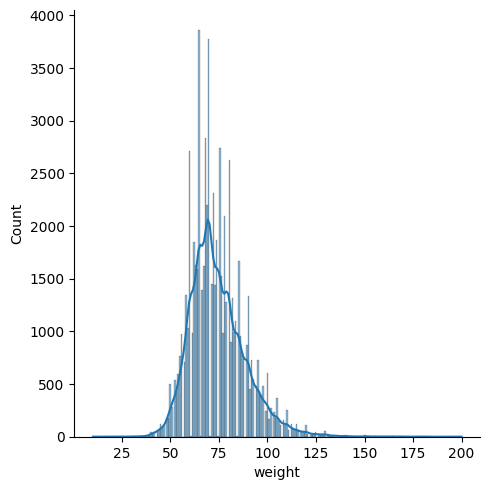

In [10]:
sns.displot(df["weight"], kde = True);

### Weight distribution by gender, showing outliers

Suggested outliers are cutting off a bit too much on the upper end, and leaving in too much on the lower end  

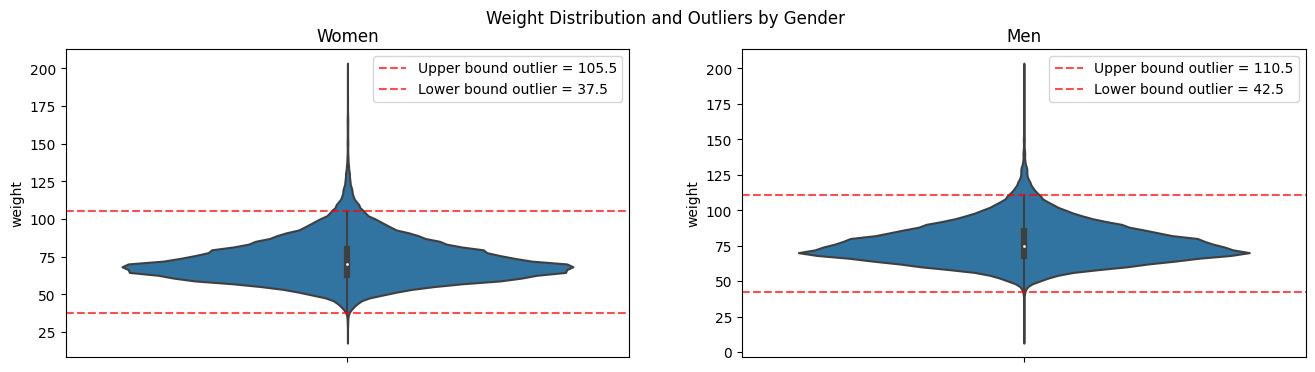

In [11]:
outliers = {"Women": calculate_outliers(df[df["gender"] == 1]["weight"]), "Men": calculate_outliers(df[df["gender"] == 2]["weight"])}
violin_outliers_by_gender(outliers, df, "weight")

Manually setting outliers like so, this cuts off the most extreme values

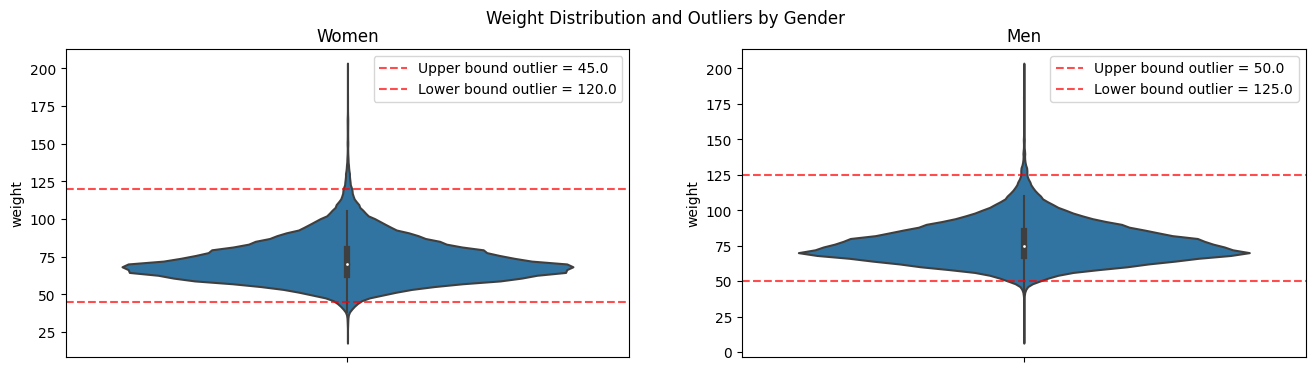

In [12]:
outliers = {"Women": (120, 45), "Men": (125, 50)}
violin_outliers_by_gender(outliers, df, "weight")

### Cleaning outliers

In [13]:
pre = len(df)

# drop women outside outliers
a = df[(df["gender"] == 1) & ((df["weight"] < 45) | (df["weight"] > 120))].index
df = df.drop(a, axis = 0)

# drop men outside outliers
c = df[(df["gender"] == 2) & ((df["weight"] < 50) | (df["weight"] > 125))].index
df = df.drop(c, axis = 0)

print(f"Dropped {pre - len(df)} rows")

Dropped 816 rows


# Height Distribution (2 F)

### Distplot with KDE

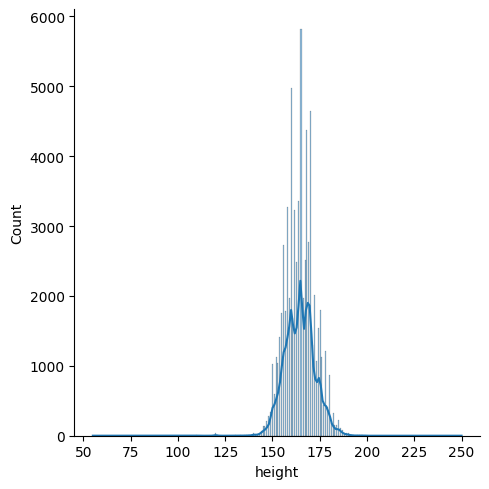

In [14]:
sns.displot(df["height"], kde = True);

### Height distribution by gender, showing outliers

These suggested outliers look more reasonable, maybe upper cutoff for height in men is a little bit too low

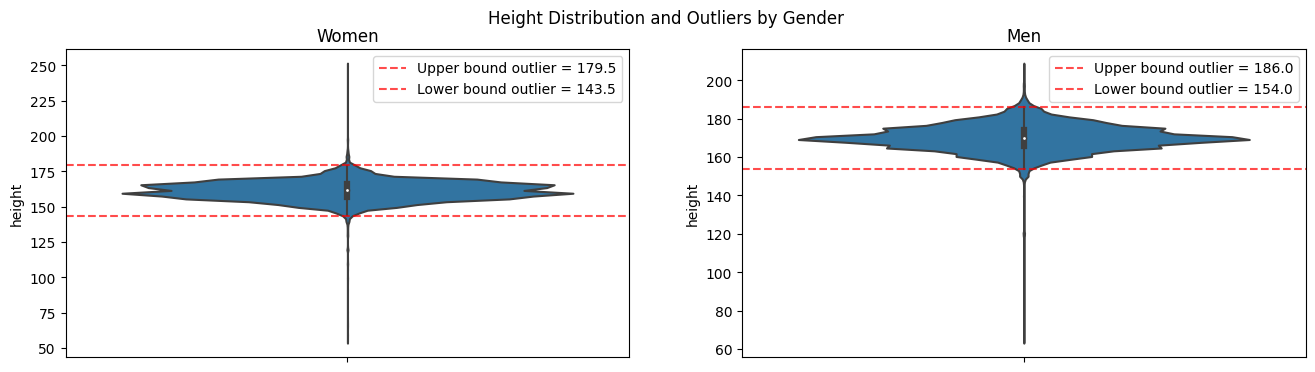

In [15]:
outliers = {"Women": calculate_outliers(df[df["gender"] == 1]["height"]), "Men": calculate_outliers(df[df["gender"] == 2]["height"])}
violin_outliers_by_gender(outliers, df, "height")

### Cleaning extreme outliers

Using suggested outliers, but changing upper height for men slightly

In [16]:
pre = len(df)

# drop women outside outliers
a = df[(df["gender"] == 1) & ((df["height"] < outliers["Women"][0]) | (df["height"] > outliers["Women"][1]))].index
df = df.drop(a, axis = 0)

# drop men outside outliers
c = df[(df["gender"] == 2) & ((df["height"] < outliers["Men"][0]) | (df["height"] > 189))].index
df = df.drop(c, axis = 0)

print(f"Dropped {pre - len(df)} rows")

Dropped 758 rows


# Disease by Sex (2 G)

### Amount of people with cardiovascular disease

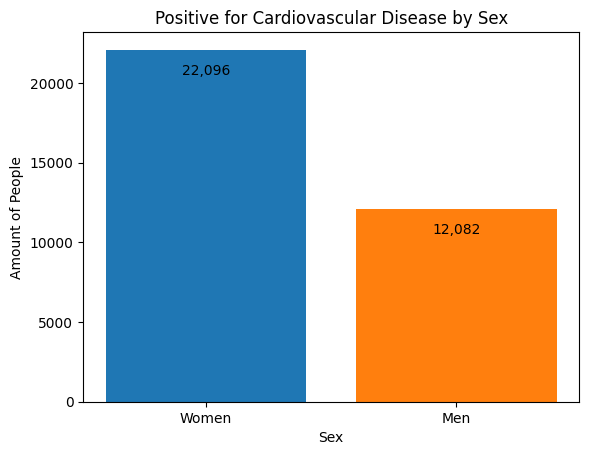

In [17]:
fig, ax = plt.subplots()

genders = {"Women": 1, "Men": 2} # dictionary with key "Gender" and value the corrsesponding number in dataset

# loop over genders
for i in genders:
    # filter out amount of datapoints where gender = gender and cardio = True
    filter = len(df[(df["gender"] == genders[i]) & (df["cardio"] == 1)])
    # plot bar under gender with height = amount of matching datapoints
    plt.bar(x = i, height = filter)

for p in ax.containers: # show and format values on bars
    ax.bar_label(p, labels = [f"{val:,.0f}" for val in p.datavalues], padding = -20)

# set labels
ax.set(title = "Positive for Cardiovascular Disease by Sex", xlabel = "Sex", ylabel = "Amount of People");

### Percentage of people with cardiovascular disease (by sex)

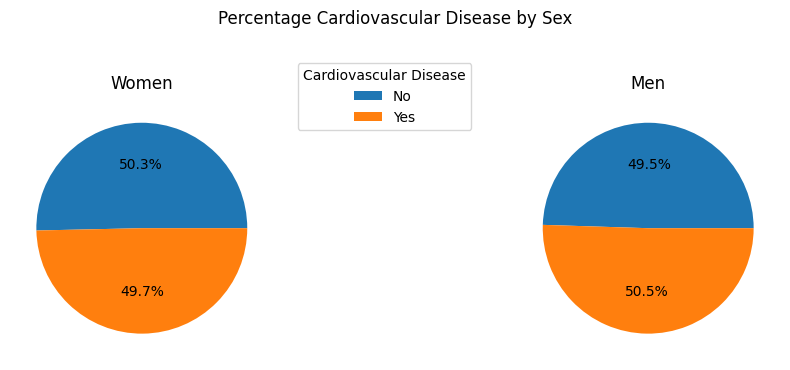

In [18]:
fig, axes = plt.subplots(1, 2, figsize = (8, 4))

# loop over gender and axes
for i, ax in zip(genders, axes.flatten()):
    # use gender values to get disease data based on gender
    total = len(df[df["gender"] == genders[i]]) # amt people in dataset
    disease = len(df[(df["gender"] == genders[i]) & (df["cardio"] == 1)]) # amt with cardiovascular
    healthy = total - disease # amt without cardiovascular

    # plot gender values in current ax
    ax.pie(x = [i for i in [healthy, disease]], autopct=lambda pct: f"{pct:.1f}%")
    ax.set_title(i) # set title based on gender key

# show legend, position in center of figure (from the point of the second subplot)
plt.legend(["No", "Yes"], title = "Cardiovascular Disease", bbox_to_anchor=(-0.5, 1), loc="center")
plt.suptitle("Percentage Cardiovascular Disease by Sex") # title for entire figure
plt.tight_layout() # update layout to exclude unused space

# Feature Engineering - BMI (2.1.0)

### Creating a BMI feature

In [19]:
df["bmi"] = df["weight"] / (df["height"] / 100) ** 2

df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
0,50,2,168,62.0,110,80,1,1,0,0,1,0,21.967120
1,55,1,156,85.0,140,90,3,1,0,0,1,1,34.927679
2,51,1,165,64.0,130,70,3,1,0,0,0,1,23.507805
3,48,2,169,82.0,150,100,1,1,0,0,1,1,28.710479
4,47,1,156,56.0,100,60,1,1,0,0,0,0,23.011177


# BMI distribution

### Distribution and Outliers by Gender

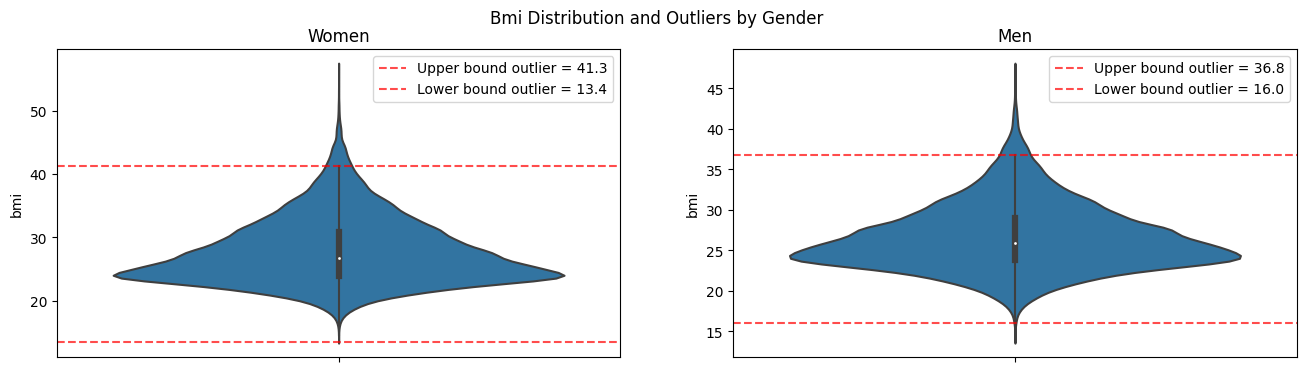

In [20]:
outliers = {"Women": calculate_outliers(df[df["gender"] == 1]["bmi"]), "Men": calculate_outliers(df[df["gender"] == 2]["bmi"])}
violin_outliers_by_gender(outliers, df, "bmi")

## BMI Classifications from WHO:

| | Moderate and Severe Thinness | Underweight | Normal Weight | Pre-obesity | Obesity Class I | Obesity Class II | Obesity Class III |  
| --- | --- | --- | --- | --- | --- | --- | --- |  
| BMI | below 17.0 | 17.0 - 18.4 | 18.5 – 24.9 | 25.0 – 29.9 | 30.0 – 34.9 | 35.0 – 39.9 | 40 or above |  

*sources:*  
[*Moderate and severe thinness, underweight, overweight and obesity*](https://apps.who.int/nutrition/landscape/help.aspx?menu=0&helpid=392&lang=EN#:~:text=BMI%20values%20indicate%20the%20following,BMI%2018.5%E2%80%9324.9%3A%20normal%20weight)  
[*A healthy lifestyle - WHO recommendations*](https://www.who.int/europe/news-room/fact-sheets/item/a-healthy-lifestyle---who-recommendations)


### Using WHO classes as base for outlier cutoffs

Underweight is between 17.0 - 18.4 which is a step of 1.5  
To cut off lower outliers while still including data for Moderate and Severe Thinness, the same step of 1.5 is used  
This gives a cutoff point for lower outliers of **15.5**

Obesity Class II is between 35.0 - 39.9 which is a step of 4.5  
To cut off upper outliers while still including data for Obesity Class III, the same step of 4.5 is used  
This gives a cutoff point for upper outliers at **45**  

As seen below, there are some differences based on gender, to make the cutoffs roughly even I will:  
- reduce the upper cutoff point for men
- increase the lower cutoff point for both men and women  

With the motivation that there are very few people outside those values

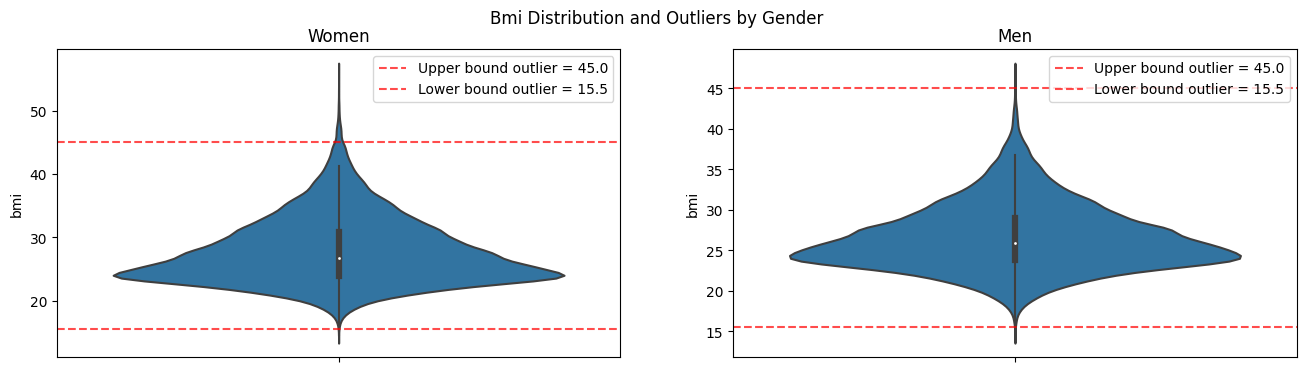

In [21]:
outliers = {"Women": (15.5, 45), "Men": (15.5, 45)}
violin_outliers_by_gender(outliers, df, "bmi")

### Adjusted WHO outliers

These cutoff points are roughly equal between genders

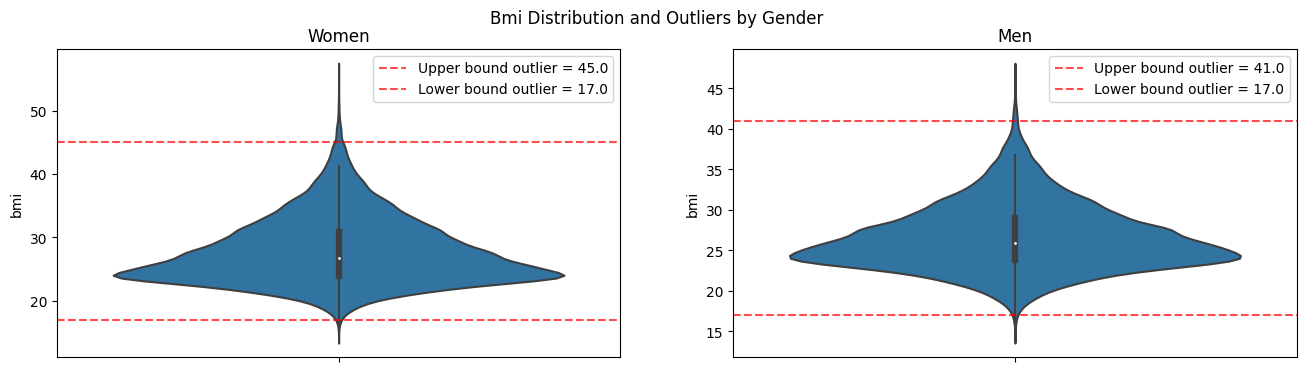

In [22]:
outliers = {"Women": (17, 45), "Men": (17, 41)}
violin_outliers_by_gender(outliers, df, "bmi")

# Removing BMI Outliers (2.1.0 A)

Removing outliers decided above  
Note that using these cutoff points, the class "Moderate and Severe Thinness" has no representation

In [23]:
pre = len(df)

# drop women outside outliers
a = df[(df["gender"] == 1) & ((df["bmi"] < 17) | (df["bmi"] > 45))].index
df = df.drop(a, axis = 0)

# drop men outside outliers
c = df[(df["gender"] == 2) & ((df["bmi"] < 17) | (df["bmi"] > 41))].index
df = df.drop(c, axis = 0)

print(f"Dropped {pre - len(df)} rows")

Dropped 312 rows


# Categorical BMI features (2.1.0 B)

### Creating categories based on WHO

Same table as used earlier for outliers:  

| BMI | Moderate and Severe Thinness | Underweight | Normal Weight | Pre-obesity | Obesity Class I | Obesity Class II | Obesity Class III |  
| --- | --- | --- | --- | --- | --- | --- | --- |  
| Value | below 17.0 | 17.0 - 18.4 | 18.5 – 24.9 | 25.0 – 29.9 | 30.0 – 34.9 | 35.0 – 39.9 | 40 or above |  
| Category | 0 | 1| 2 | 3 | 4 | 5 | 6 |  

In [24]:
# create bins where each category is included between one value and the next
cutoff_bins = [0, 17, 18.5, 25, 30, 35, 40, 46] # end on 46 to include 40-45

# cut bmi based on bins, label 0-6 based on labels, right = False excludes upper value from being included
df["bmi_category"] = pd.cut(df["bmi"], bins = cutoff_bins, labels=[i for i in range(len(cutoff_bins) - 1)], right = False).astype(int)

df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,bmi_category
0,50,2,168,62.0,110,80,1,1,0,0,1,0,21.967120,2
1,55,1,156,85.0,140,90,3,1,0,0,1,1,34.927679,4
2,51,1,165,64.0,130,70,3,1,0,0,0,1,23.507805,2
3,48,2,169,82.0,150,100,1,1,0,0,1,1,28.710479,3
4,47,1,156,56.0,100,60,1,1,0,0,0,0,23.011177,2


# BMI Category Distribution

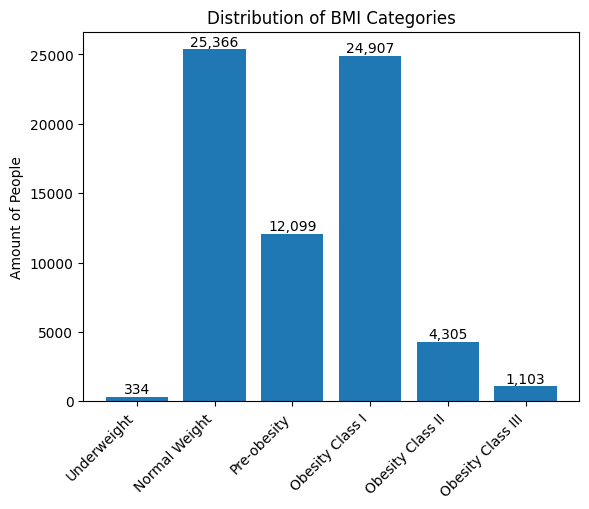

In [25]:
fig, ax = plt.subplots()

# plot amount of measurements in each unique category
plt.bar(x = df["bmi_category"].unique(), height = df["bmi_category"].value_counts());

# create list of labels
bmi_labels = ["Underweight", "Normal Weight", "Pre-obesity", "Obesity Class I", "Obesity Class II", "Obesity Class III"]

# map list to xticks, rotate and align to tick positions
plt.xticks(sorted(df["bmi_category"].unique()), labels = bmi_labels, rotation = 45, ha = "right");

for p in ax.containers: # show and format values on bars
    ax.bar_label(p, labels = [f"{val:,.0f}" for val in p.datavalues], padding = 0)

# set labels
ax.set(title = "Distribution of BMI Categories", ylabel = "Amount of People");

# Blood Pressure (2.1.1)

### Due to extreme values, data is hard to visualize properly:

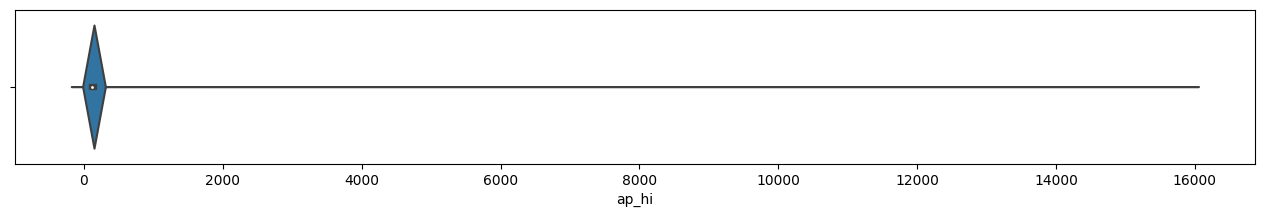

In [26]:
plt.subplots(figsize = (16, 2))
sns.violinplot(x = df["ap_hi"]);

### Removing very extreme outliers to allow for better analysis

Based on [hypotension](https://en.wikipedia.org/wiki/Hypotension) (low blood pressure) and [hypertension](https://en.wikipedia.org/wiki/Hypertension) (high blood pressure) levels being at 90/60 and 120/80 respectively, with [hypertensive crisis](https://en.wikipedia.org/wiki/Hypertensive_crisis) (severely elevated blood pressure) at 180/120; outliers extremely different from these values can be removed to allow for better analysis

In [27]:
# variable to keep track of how many datapoints are removed
pre = len(df)

# cutoff points set to half of low and twice of severely high threshold
df = df[df["ap_hi"].between(45, 360)]
df = df[df["ap_lo"].between(30, 240)]

# Plotting Blood Pressure

### Calculate Tukey's for ap_hi and ap_lo

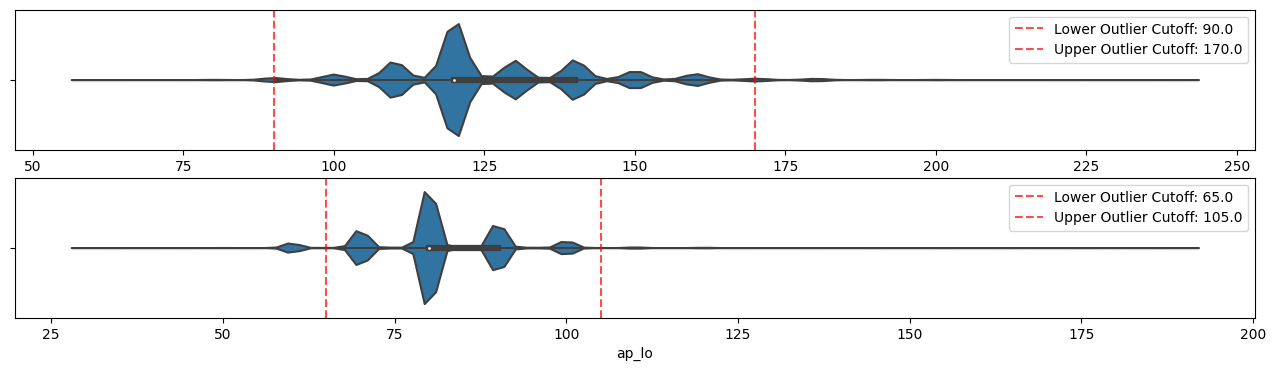

In [28]:
outliers = {"ap_hi": calculate_outliers(df["ap_hi"]), "ap_lo": calculate_outliers(df["ap_lo"])}

fig, axes = plt.subplots(2, 1, figsize = (16, 4))

# loop through axes and outliers
for ax, ap in zip(axes.flatten(), outliers):
    sns.violinplot(x = df[ap], ax = ax) # plot ap in ax

    # plot vertical lines to show outliers
    ax.axvline(outliers[ap][0], color = "r", linestyle = "--", alpha = 0.7, label = f"Lower Outlier Cutoff: {outliers[ap][0]:.1f}")
    ax.axvline(outliers[ap][1], color = "r", linestyle = "--", alpha = 0.7, label = f"Upper Outlier Cutoff: {outliers[ap][1]:.1f}")
    ax.legend(loc = "upper right") # show vertical line legend in top right corner

# Dropping Blood Pressure Values

### Suggested outliers align fairly well with the low and severely high categories:  

### ap_hi:  
low bp: 90  
suggested cutoff: 90  

severe bp: 180  
suggested cutoff: 170  

### ap_lo:  
low bp: 60  
suggested cutoff: 65  

severe bp: 120  
suggested cutoff: 105  

### Since they lign up well, data is cleaned based on nearest category of suggested outlier cutoffs:

In [29]:
# TODO: link to category values used
df = df[df["ap_hi"].between(90, 180)]
df = df[df["ap_lo"].between(60, 120)]

print(f"Datapoints removed: {pre - len(df)}")

Datapoints removed: 1710


In [30]:
pre = len(df)

# TODO: credit Daniel for idea to remove measurements where diastolic bp is higher than systolic
df = df[df['ap_hi'] > df['ap_lo']]

print(f"Datapoints removed: {pre - len(df)}")

Datapoints removed: 4


# Categorical Blood Pressure Features

In [31]:
conditions = [
    (df['ap_hi'] < 120) & (df['ap_lo'] < 80), # healthy -> label 0
    (df['ap_hi'] < 130) & (df['ap_lo'] < 80), # elevated -> label 1
    (df['ap_hi'] < 140) | (df['ap_lo'] < 90), # stage 1 -> label 2
    (df['ap_hi'] < 180.1) | (df['ap_lo'] < 120.1) # stage 2 -> label 3 (+.1 to be inclusive as per the suggested ranges)
] # none of the above (stage 3) -> label 4

labels = [0, 1, 2, 3]

# using numpy for vectorized application of categories
df['bp_category'] = np.select(conditions, labels, 4) # check conditions, apply value, if none was matched set to 4

df["bp_category"].value_counts().sort_index()

0     9118
1     3030
2    40758
3    13494
Name: bp_category, dtype: int64

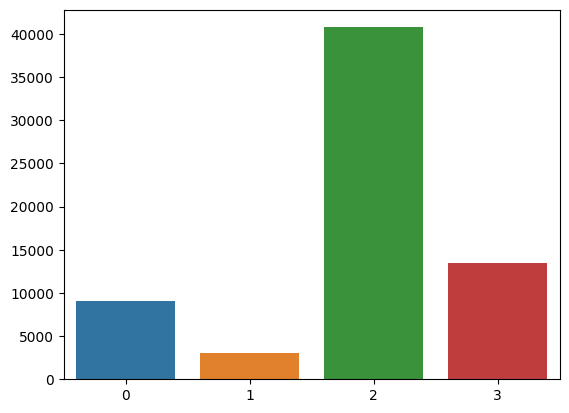

In [32]:
# TODO: finish up plot
sns.barplot(x = df["bp_category"].value_counts().sort_index().index, y = df["bp_category"].value_counts().sort_index().values);

# Amount Positive Cardiovascular Based on Different Features (2.2.0)

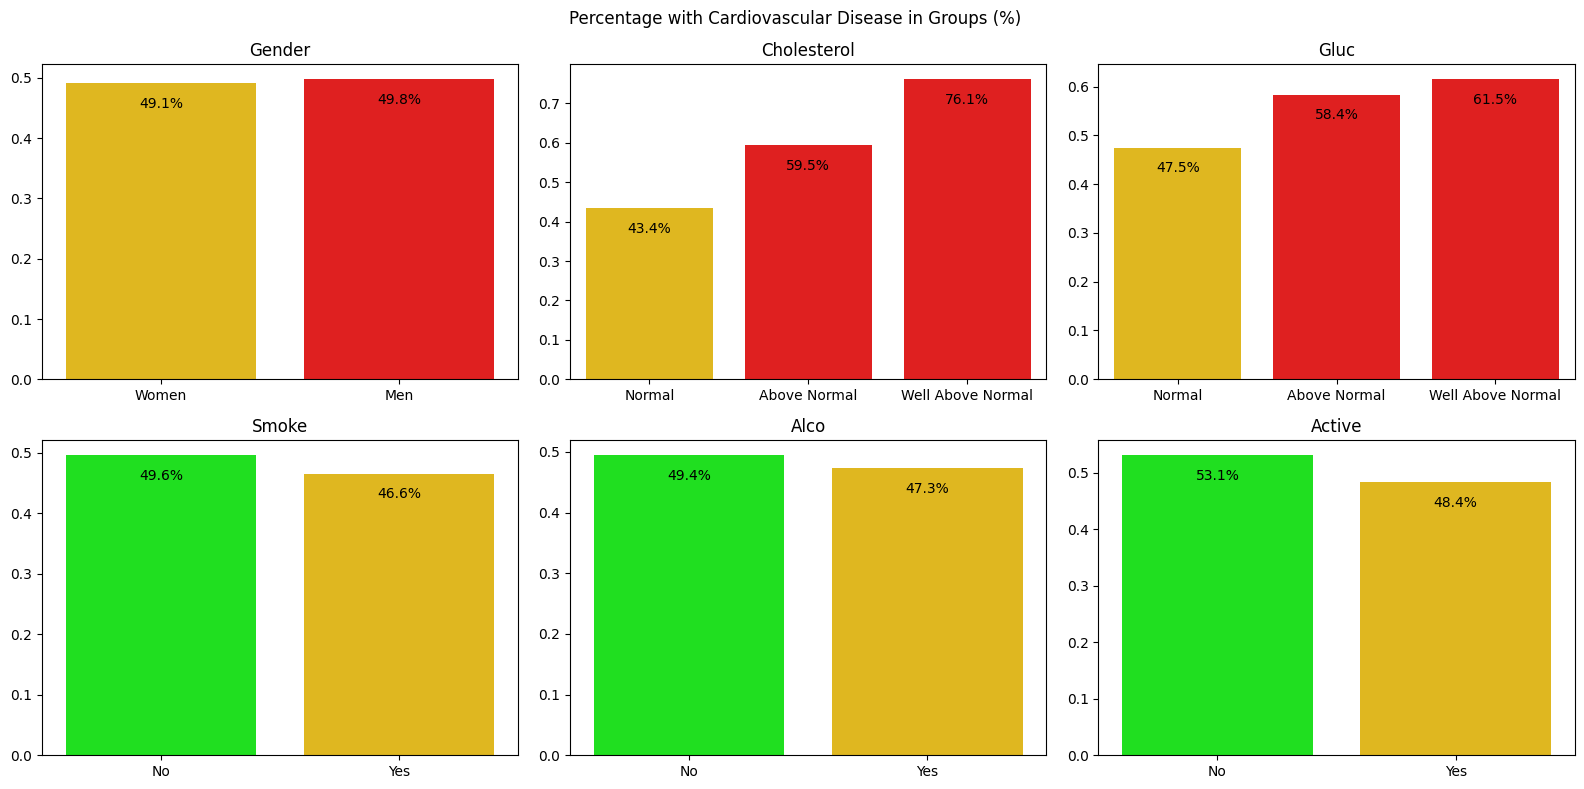

In [33]:
# TODO: finish up this and next plot
cols = {
    "gender": ["Women", "Men"],
    "cholesterol": ["Normal", "Above Normal", "Well Above Normal"],
    "gluc": ["Normal", "Above Normal", "Well Above Normal"],
    "smoke": ["No", "Yes"],
    "alco": ["No", "Yes"],
    "active": ["No", "Yes"],
}

# create color palette
palette = sns.color_palette("rocket", len(cols))
palette = sns.color_palette("blend:lime,yellow,orange,red,red,red,red,red,red", len(cols))

# create subplots
fig, axes = plt.subplots(2, 3, figsize = (16, 8))

# loop through subplots and columns dictionary
for ax, col in zip(axes.flatten(), cols.keys()):

    # calculate amount with cardiovascular disease based on column
    data = df[df["cardio"] == 1][col].value_counts().sort_index() / df[col].value_counts()

    # palette = sns.color_palette("rocket", len(data))

    # plot data
    sns.barplot(x = data.index, y = data.values, palette = np.array(palette)[data.index], ax = ax, color=data.values) # [::-1] for inverse order # np.array(palette)[data.index]

    for p in ax.containers: # show and format values on bars
        ax.bar_label(p, labels = [f"{val*100:,.1f}%" for val in p.datavalues], padding = -20)

    # set title and labels
    ax.set_title(col.title())
    ax.set_xticklabels(cols[col]) # , rotation = 45, ha = "right"

plt.suptitle("Percentage with Cardiovascular Disease in Groups (%)");
plt.tight_layout()

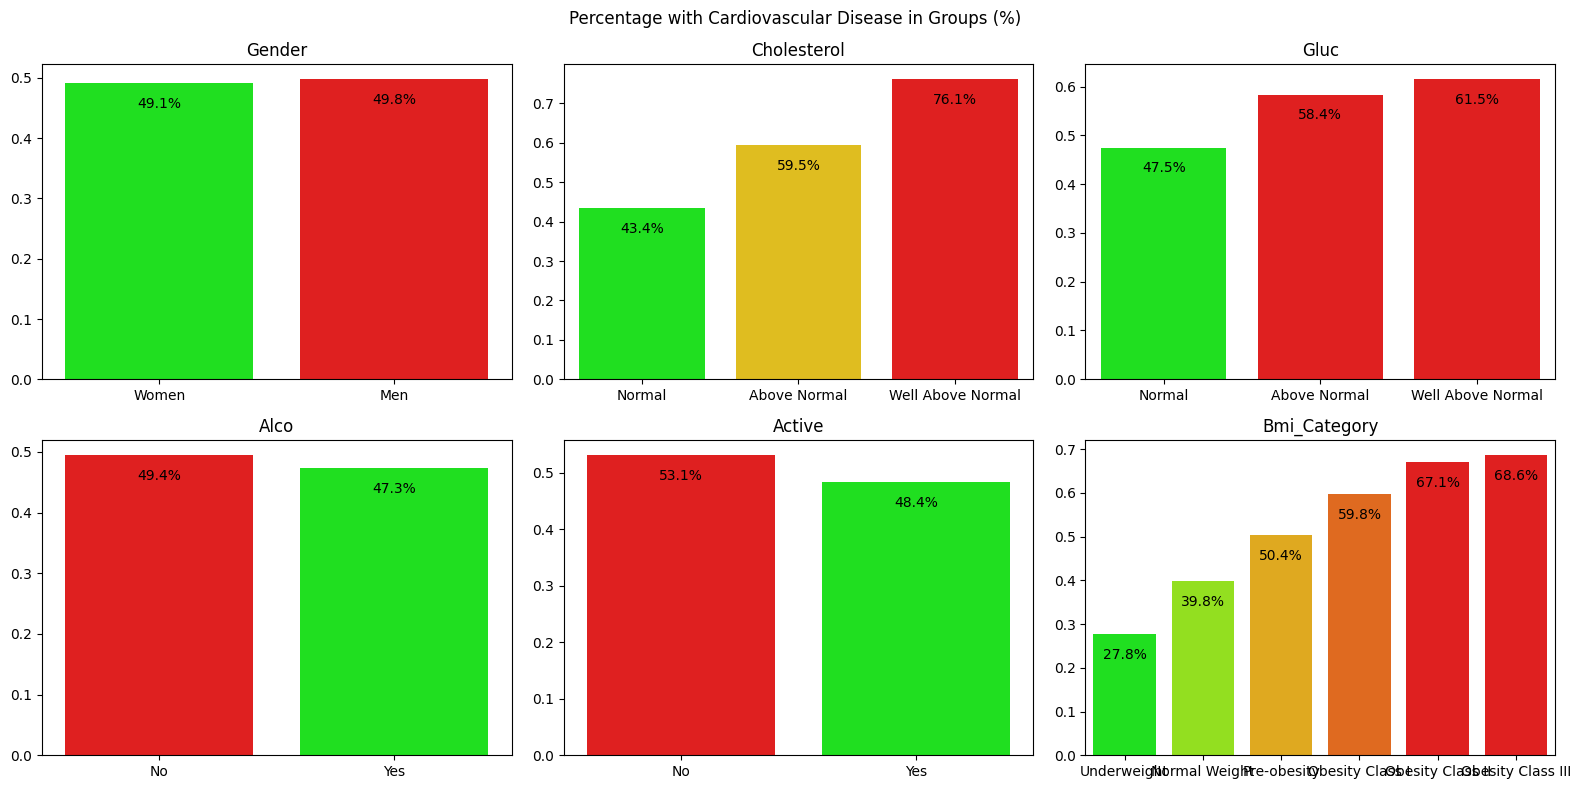

In [34]:
cols = {
    "gender": ["Women", "Men"],
    "cholesterol": ["Normal", "Above Normal", "Well Above Normal"],
    "gluc": ["Normal", "Above Normal", "Well Above Normal"],
    #"smoke": ["No", "Yes"],
    "alco": ["No", "Yes"],
    "active": ["No", "Yes"],
    "bmi_category": bmi_labels,
}

# create subplots
fig, axes = plt.subplots(2, 3, figsize = (16, 8))

# loop through subplots and columns dictionary
for ax, col in zip(axes.flatten(), cols.keys()):

    # calculate amount with cardiovascular disease based on column
    data = df[df["cardio"] == 1][col].value_counts().sort_index() / df[col].value_counts()

    # create color palette based on y-values
    palette = sns.color_palette("blend:lime,yellow,orange,red", len(data))

    # credit ChatGPT for making palette color based on y-values instead of x-values
    y_norm = (data.values - data.values.min()) / (data.values.max() - data.values.min())  # normalize y-values
    y_colors = np.array(palette)[np.round(y_norm * (len(palette) - 1)).astype(int)]  # map y-values to colors

    # plot data and color bars based on y-values
    sns.barplot(x=data.index, y=data.values, palette=y_colors, ax=ax)

    for p in ax.containers: # show and format values on bars
        ax.bar_label(p, labels=[f"{val*100:,.1f}%" for val in p.datavalues], padding=-20)

    # set title and labels
    ax.set_title(col.title())
    ax.set_xticklabels(cols[col])

plt.suptitle("Percentage with Cardiovascular Disease in Groups (%)")
plt.tight_layout()

# Correlation Plot (2.2.1)

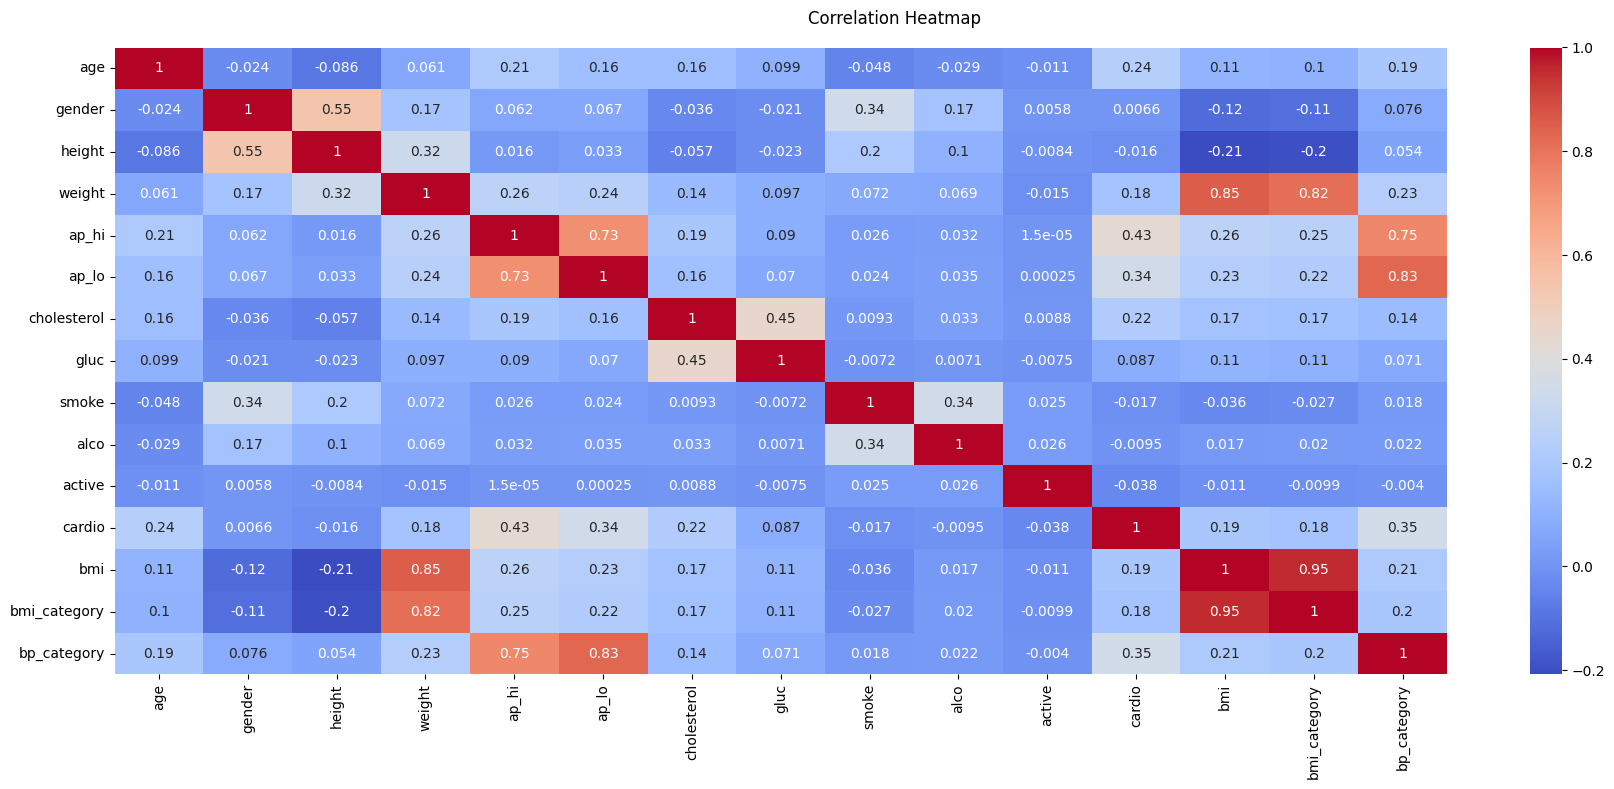

In [35]:
plt.figure(figsize = [18, 8])

corr = df.corr()
sns.heatmap(corr, cmap = "coolwarm", annot = True)
plt.suptitle('Correlation Heatmap')
plt.tight_layout()

# TODO: explain correlation

# Save Cleaned Dataset

### Data analysis complete, saving dataframe as cleaned csv

Clean dataset is loaded in split_dataset.ipynb

In [36]:
# df.to_csv("assets/cardio_train_cleaned.csv", index = False)